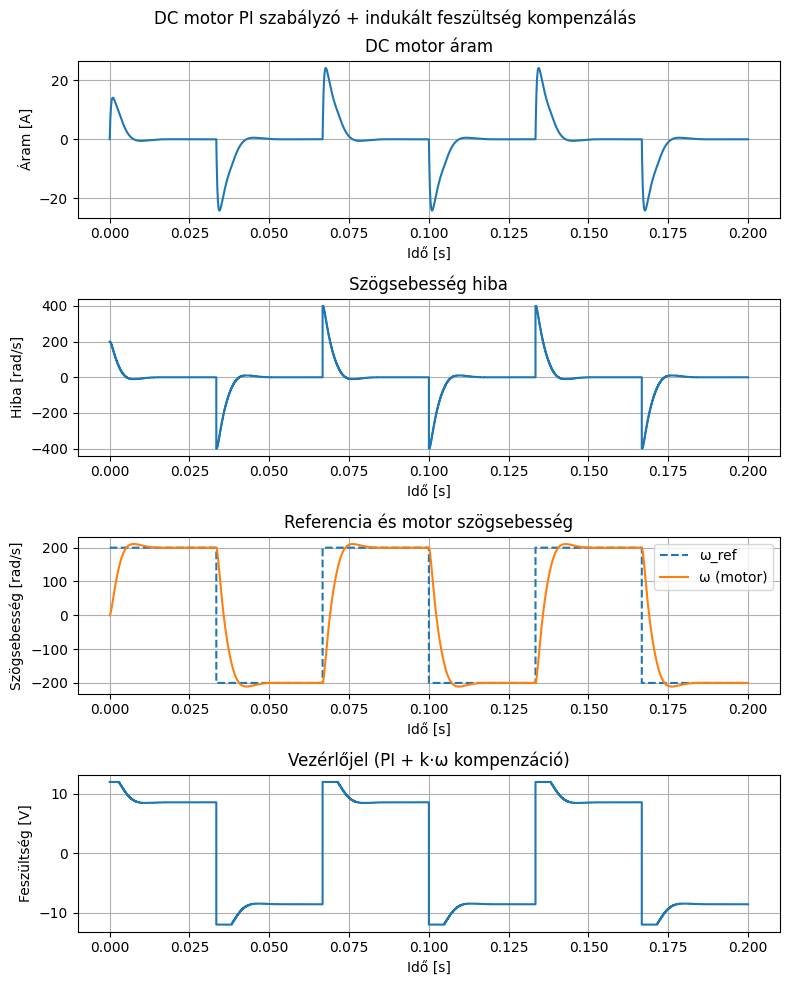

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Motor ODE függvény
def motorODE(t, x, u, R, L, k, J, b, T_load):
    """
    x = [i, omega]
    """
    i, omega = x
    di_dt = (u - R*i - k*omega) / L
    domega_dt = (k*i - b*omega - T_load) / J
    return [di_dt, domega_dt]

# --- Paraméterek ---
# Motor paraméterek
R      = 0.716      # Armatúra ellenállás [ohm]
L      = 0.00026    # Armatúra induktivitás [H]
k      = 0.0429     # Motor állandó (Nm/A vagy V/(rad/s))
J      = 1e-5       # Tehetetlenségi nyomaték [kg*m^2]
b      = 0.0        # Viszkózus súrlódás [N*m*s/rad]
T_load = 0.0        # Terhelő nyomaték [Nm]

# PI szabályozó paraméterek
Kp   = 0.1    # Arányos erősítés
Ki   = 275    # Integrális erősítés
Vmax = 12.0   # Feszültség szaturáció (±V)

# Referencia jel (négyszögjel) paraméterek
w_high = 200      # Felső szögsebesség [rad/s]
w_low  = -200     # Alsó szögsebesség [rad/s]
freq   = 15       # Négyszögjel frekvencia [Hz]

# Szimulációs beállítások
t_max         = 0.2      # Teljes szimulációs idő [s]
dt_controller = 1e-4     # Szabályozó frissítési időköz [s]

# --- Inicializáció ---
# Kezdeti állapot: [i, omega]
state = np.array([0.0, 0.0])
# Kezdeti integrált hiba
e_int = 0.0
# Aktuális idő
t_current = 0.0

# Eredmények tárolása
T_all     = []
I_all     = []
Omega_all = []
U_all     = []
Wref_all  = []
error_all = []

# --- Szimuláció ---
while t_current < t_max:
    # Négyszögjel periódus
    T_period = 1.0 / freq

    # Referenciajel (négyszög) számítása
    if (t_current % T_period) < (T_period / 2.0):
        w_ref = w_high
    else:
        w_ref = w_low

    # Hibaszámítás (hiba = referencia - aktuális omega)
    error_val = w_ref - state[1]

    # --- PI rész (diszkrét frissítés közelítésével) ---
    # A tiszta PI-kimenet:
    u_pi = Kp * ( error_val + Ki * dt_controller * (e_int + error_val) )

    # --- Indukált feszültség (back-EMF) kompenzálás ---
    u_ff = k * state[1]  # k·omega

    # Teljes vezérlőjel:
    u_raw = u_pi + u_ff

    # Szaturáció (±Vmax)
    if u_raw > Vmax:
        u = Vmax
        int_flag = False  # integrátor fagyasztása
    elif u_raw < -Vmax:
        u = -Vmax
        int_flag = False
    else:
        u = u_raw
        int_flag = True

    # Integrátor frissítése (ha nincs telítés)
    if int_flag:
        e_int += error_val

    # A következő intervallum vége
    t_interval_end = min(t_current + dt_controller, t_max)

    # Motor dinamikájának integrációja solve_ivp-vel (a vezérlőjel konstans a dt_controller hosszú lépcsőben)
    sol = solve_ivp(
        fun=lambda t, x: motorODE(t, x, u, R, L, k, J, b, T_load),
        t_span=[t_current, t_interval_end],
        y0=state,
        # t_eval=...  # Ha menet közbeni mintavételeket akarunk, megadhatunk pontokat
    )

    # Eredmények tárolása
    T_segment     = sol.t
    I_segment     = sol.y[0]
    Omega_segment = sol.y[1]

    # Minden pontban ugyanaz a referencia és error ebben a dt_controller intervallumban
    U_segment     = np.full_like(T_segment, u)
    Wref_segment  = np.full_like(T_segment, w_ref)
    Err_segment   = np.full_like(T_segment, error_val)

    T_all.append(T_segment)
    I_all.append(I_segment)
    Omega_all.append(Omega_segment)
    U_all.append(U_segment)
    Wref_all.append(Wref_segment)
    error_all.append(Err_segment)

    # Állapot frissítése a következő ciklusra
    state = np.array([I_segment[-1], Omega_segment[-1]])
    t_current = t_interval_end

# A listák összefűzése egy-egy numpy tömbbé
T_all     = np.concatenate(T_all)
I_all     = np.concatenate(I_all)
Omega_all = np.concatenate(Omega_all)
U_all     = np.concatenate(U_all)
Wref_all  = np.concatenate(Wref_all)
error_all = np.concatenate(error_all)

# --- Ábrázolás ---
plt.figure(figsize=(8,10))
plt.suptitle("DC motor PI szabályzó + indukált feszültség kompenzálás")

# 1. ábra: Áram
plt.subplot(4,1,1)
plt.plot(T_all, I_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Áram [A]')
plt.title('DC motor áram')
plt.grid(True)

# 2. ábra: Hiba
plt.subplot(4,1,2)
plt.plot(T_all, error_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Hiba [rad/s]')
plt.title('Szögsebesség hiba')
plt.grid(True)

# 3. ábra: Szögsebesség + referencia
plt.subplot(4,1,3)
plt.plot(T_all, Wref_all, '--', linewidth=1.5, label='ω_ref')
plt.plot(T_all, Omega_all, linewidth=1.5, label='ω (motor)')
plt.xlabel('Idő [s]')
plt.ylabel('Szögsebesség [rad/s]')
plt.title('Referencia és motor szögsebesség')
plt.legend()
plt.grid(True)

# 4. ábra: Vezérlőjel
plt.subplot(4,1,4)
plt.plot(T_all, U_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Feszültség [V]')
plt.title('Vezérlőjel (PI + k·ω kompenzáció)')
plt.grid(True)

plt.tight_layout()
plt.show()
